# Network Simplex for Discrete Optimal Transport

In [1]:
from PIL import Image
import numpy as np
import scipy.sparse as sps
from scipy.fft import dct, idct
import matplotlib.pyplot as plt
from ipycanvas import Canvas, hold_canvas

# Discrete Optimal Transport: Problem Statement

Let $\mu$ and $\nu$ be atomic measures on $\mathbb R^2$, with $n$ and $m$ atoms, respectively. Then, fixing an order of the atoms, 
$$
    \mu \leftrightarrow \mathbf u \in \mathbb R^n
    \qquad \text{and}\qquad
    \nu \leftrightarrow \mathbf v \in \mathbb R^m 
$$
Given a cost function $\mathbf C \in \mathbb R^{n\times m}$, we want to compute an optimal transport plan $\mathbf P \in \mathbb R^{n\times m}$ such that the following target function is minimized:
$$
    \mathcal P(\mathbf P; \mathbf C) = \sum_{i,j} \mathbf C_{ij} \mathbf P_{ij}
    \tag{$\mathcal P$}
$$
$\mathbf P$ being a transport plan means that the sum along the rows gives the vector $\mathbf v$ and the sum along the column gives the vector $\mathbf u$.
$$
    \sum_{j} \mathbf P_{ij} = \mathbf v_i
    \qquad
    \sum_{i} \mathbf P_{ij} = \mathbf u_j
$$

In [2]:
def img2bw(filenames, shape=None):
    ''' return black and white version of images '''
    results = []
    for filename in filenames:
        img = Image.open(filename).convert('1')
        results.append(np.array(img if shape is None else img.resize(shape)).astype(int))
    return results

In [35]:
filenames = ['img/jonathan_joestar.jpg', 'img/dio_jojos.jpg']
img_size = (45, 90)  #  W, H
images = img2bw(filenames, shape=img_size)
coords = [np.nonzero(img.ravel() == 0)[0] for img in images]

print(coords[0])
print(coords[1])

[   35    44    45 ... 16197 16198 16199]
[   25    26    29 ... 16197 16198 16199]


In [36]:
def get_physical_coords(coords):
    ''' (r, c) --flat--> r*W + c =: k  --unflat--> r = (k // W)  and  c = k % W '''
    return np.mod(coords, img_size[0]), np.floor_divide(coords, img_size[0])

In [37]:
canvas_scaling = 6
canvas_size = canvas_scaling*img_size[0], canvas_scaling*img_size[1]

canvas = Canvas(width=2.5*canvas_size[0], height=canvas_size[1])

x1, y1 = get_physical_coords(coords[0])
x2, y2 = get_physical_coords(coords[1])

canvas.fill_style = 'red'
canvas.fill_circles(canvas_scaling*x1, canvas_scaling*y1, 1.0)

canvas.fill_style = 'blue'
canvas.fill_circles(canvas_scaling*(x2 + 1.5*img_size[0]), canvas_scaling*y2, 1.0)

canvas

Canvas(height=1080, width=1350)

# Network Simplex Algorithm

Recall that the dual problem of $(\mathcal P)$ is defined as the maximimization problem of
$$
    \mathcal D(\mathbf f, \mathbf g; \mathbf C) = \mathbf u \cdot \mathbf f + \mathbf v \cdot \mathbf g
    \tag{$\mathcal D$}
$$
such that $\mathbf f \oplus \mathbf g \le C$ (i.e. $\mathbf f_i + \mathbf g_j \le \mathbf C_{ij}$).

Moreover, recall that our problem can be associated to a graph problem: let $G=(V,E)$ be the complete bipartite graph on $n+m$ vertices. Consider the subset of edges induced by the transport plan $\mathbf P$
$$
    S(\mathbf P) = \lbrace (a,b) \in E \text{ s.t } \mathbf P_{ab} > 0 \rbrace
$$
Then, the subgraph $H=(V,S(\mathbf P))$ can be associated to $\mathbf P$. If we allow weighted edges, then we have correspondence.

Algorithm description:
1. Build a feasible primal $\mathbf P$ (i.e. using the North West rule).
2. Build a feasible dual pair $(\mathbf f, \mathbf g)$ (i.e. propagating an initial condition)
3. If the feasible dual pair is optimal, we are done. Otherwise, there exists an index pair $(a,b)$ s.t. $\mathbf f_a + \mathbf g_b > \mathbf C_{ab}$. Add the edge $(a,b)$ to $H$. With the added edge, two situations may arise:
    + $H$ is (still) a forest. Go to step 2. with the new graph $H$. This single step does not modify $\mathbf P$.
    + $H$ now has a cycle. We need to remove one edge so that $H$ is a forest. Let $e_1 e_2 \cdots e_k$ be the cycle, with $e_1 = (a,b)$. Pick $e_t$ the minimum weighted edge in the cycle (i.e. $e_t = \mathrm{argmin}_{k} \mathbf P_{e_k}$). Then, perform the following modification of $\mathbf P$:
      $$
          \mathbf P_{e_{t+s}} = \mathbf P_{e_{t+s}} + (-1)^{s+1} \mathbf P_{e_t}
          \quad s=0,\ldots,k-1
      $$
      where the index must be taken modulo $k+1$. Since $P_{e_t}$ is now zero, the graph $H$ is (again) a forest. Go to step 2.

In [38]:
def find_feasible_P(u, v):
    ''' Apply northwest rule to build a transport plan '''
    n, m = len(u), len(v)
    P = sps.lil_matrix((n, m))
    i = 0
    j = 0
    r = int(u[0])
    c = int(v[0])
    while True:
        t = min(r, c)
        P[i, j] = t
        r = r - t
        c = c - t
        if r == 0:
            i += 1
            if i >= n:
                break
            r = int(u[i])
        if c == 0:
            j += 1
            if j >= m:
                break
            c = int(v[j])
    return P.astype(int)

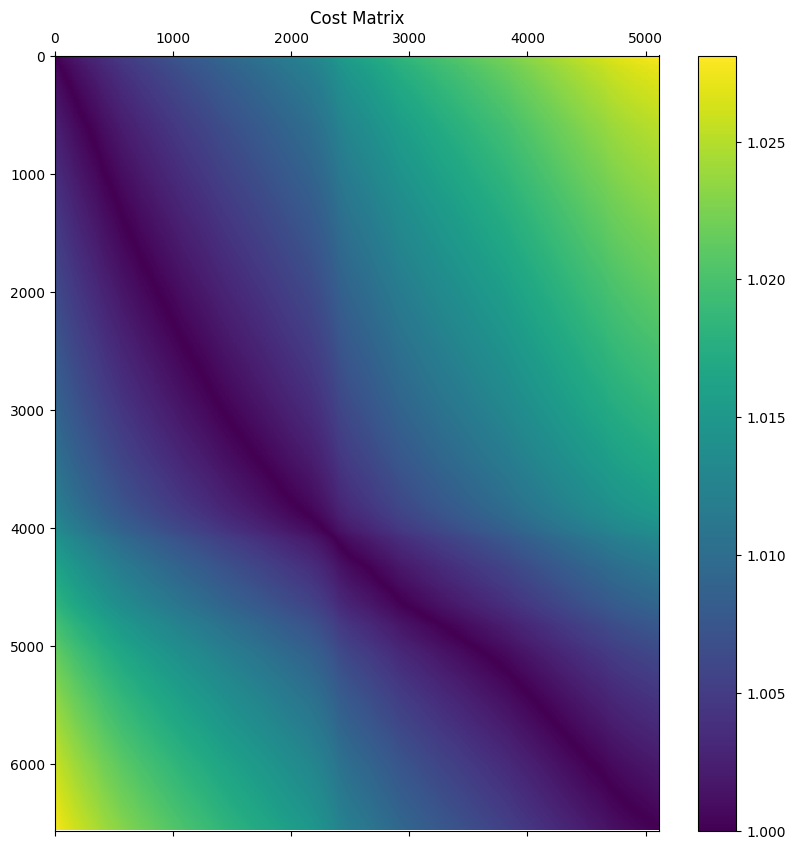

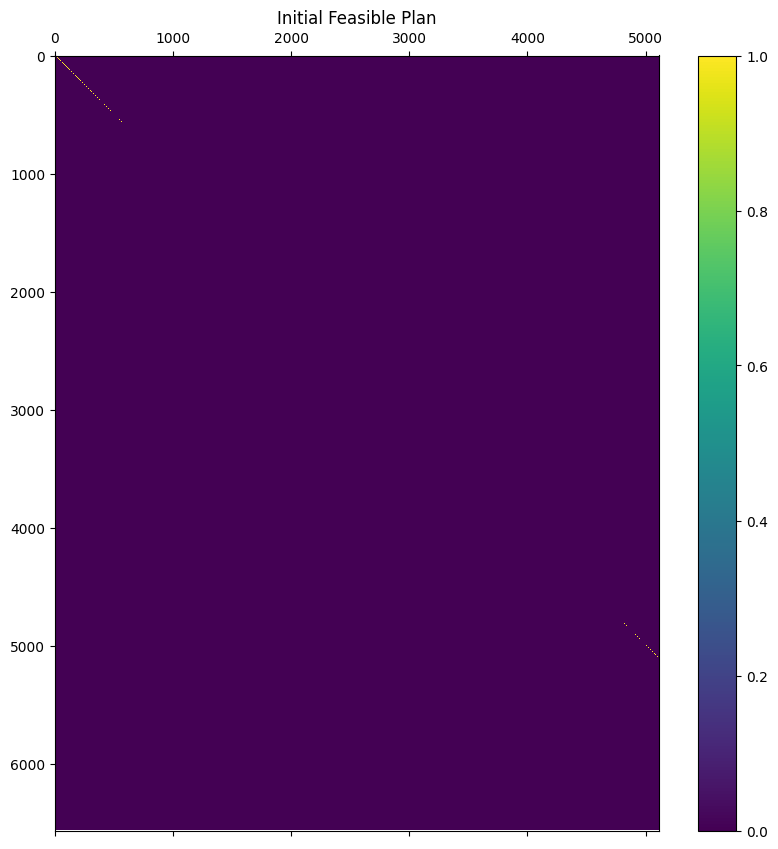

In [39]:
u = np.ones(len(coords[0]))
v = np.ones(len(coords[1]))

n = len(u)
m = len(v)

C = np.exp(np.abs(np.subtract.outer(coords[0], coords[1]))/(canvas_size[0]*canvas_size[1]))
plt.figure(figsize=(10, 10))
plt.matshow(C, fignum=1)
plt.title('Cost Matrix')
plt.colorbar(location='right')
plt.show()

P = find_feasible_P(u, v)
plt.figure(figsize=(10, 10))
plt.matshow(P.todense(), fignum=1)
plt.title('Initial Feasible Plan')
plt.colorbar(location='right')
plt.show()

In [40]:
#  Build Graph
V = list(range(n+m))
Srow, Scol = P.nonzero()
S = list(zip(map(int, Srow), map(int, Scol + n)))

In [41]:
visual_graph = Canvas(width=2.5*canvas_size[0], height=canvas_size[1])

with hold_canvas(canvas=visual_graph):
    visual_graph.fill_style = 'red'
    visual_graph.fill_circles(canvas_scaling*x1, canvas_scaling*y1, 1.0)
    
    visual_graph.fill_style = 'blue'
    visual_graph.fill_circles(canvas_scaling*(x2 + 1.5*img_size[0]), canvas_scaling * y2, 1.0)
    
    visual_graph.line_width = 0.2
    visual_graph.stroke_style = 'black'
    for (i, j) in S:
        visual_graph.stroke_line(canvas_scaling*x1[i], canvas_scaling*y1[i], canvas_scaling*(x2[j-n] + 1.5*img_size[0]), canvas_scaling*y2[j-n])

visual_graph

Canvas(height=1080, width=1350)

In [10]:
def find_neighbors(V, S, idx, exclude=[]):
    return [k for k in range(n+m) if k not in exclude and ((idx, k) in S or (k, idx) in S)]

In [11]:
def propagate(i, j, start_f=True):
    to_visit = []
    visited = []

    fg = np.zeros(n+m)
    
    if start_f:
        to_visit += find_neighbors(V, S, i)
        visited.append(i)
    else:
        to_visit += find_neighbors(V, S, j)
        visited.append(j)

    g_turn = start_f
    while len(to_visit) > 0:
        if g_turn:
            next_visit = []
            for j in to_visit:
                fg[j] = C[i, j-n] - fg[i]
                next_visit += find_neighbors(V, S, j, exclude=visited)
                visited.append(j)
            to_visit = next_visit
        else:
            next_visit = []
            for i in to_visit:
                i = to_visit.pop()
                fg[i] = C[i, j-n] - fg[j]
                next_visit += find_neighbors(V, S, i, exclude=visited)
                visited.append(i)
            to_visit = next_visit
        g_turn = not g_turn
    return np.split(fg, [n])

In [12]:
f, g = propagate(0, 2)

print('f', f)
print('g', g)
print('C - f+g')
print(C-np.add.outer(f, g))

f [0. 0. 0. ... 0. 0. 0.]
g [1.00001372 0.         0.         ... 0.         0.         0.        ]
C - f+g
[[ 0.00000000e+00  1.00003429e+00  1.00006173e+00 ...  1.02801910e+00
   1.02803320e+00  1.02804025e+00]
 [-6.85878113e-06  1.00002744e+00  1.00005487e+00 ...  1.02801205e+00
   1.02802615e+00  1.02803320e+00]
 [-6.85878113e-06  1.00001372e+00  1.00004115e+00 ...  1.02799795e+00
   1.02801205e+00  1.02801910e+00]
 ...
 [ 2.79983298e-02  1.02799090e+00  1.02796269e+00 ...  1.00000686e+00
   1.00000686e+00  1.00001372e+00]
 [ 2.80053807e-02  1.02799795e+00  1.02796974e+00 ...  1.00001372e+00
   1.00000000e+00  1.00000686e+00]
 [ 2.80124316e-02  1.02800500e+00  1.02797679e+00 ...  1.00002058e+00
   1.00000686e+00  1.00000000e+00]]
